## Demo Linear regression - V1 - State là vector thể hiện trạng thái hiện tại

In [2]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import joblib, os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib, pathlib

### Linear regression trên từng dạng bài và từng section trong 1 chương

In [3]:
df_c0 = pd.read_csv("data/cluster0.csv")
df_c1 = pd.read_csv("data/cluster1.csv")
# Đọc dữ liệu từ file CSV
csv_path = "data/student_logs_chapter1_full.csv"
df_full = pd.read_csv(csv_path)

def train_models_for_cluster(df, section_list, levels=["easy", "medium", "hard"]):
    models = {}

    for section in section_list:
        for level in levels:
            key = f"{level}_{section}"

            # Tạo danh sách feature
            base_cols = [
                f"video_views_{section}",
                f"pdf_views_{section}",
                "forum_post_count",
                "assignment_status",
                "cluster"
            ]

            if level == "medium":
                base_cols.insert(2, f"quiz_avg_easy_{section}")
            elif level == "hard":
                base_cols.insert(2, f"quiz_avg_easy_{section}")
                base_cols.insert(3, f"quiz_avg_medium_{section}")

            # Huấn luyện
            X = df[base_cols]
            y = df[f"quiz_avg_{level}_{section}"]

            model = LinearRegression()
            model.fit(X, y)

            models[key] = model

    return models

In [4]:
# Tất cả các mục học trong chương 1
sections = [f"1_{i}" for i in range(1, 8)]  # từ 1_1 đến 1_7

models_c0 = train_models_for_cluster(df_c0, section_list=sections)
models_c1 = train_models_for_cluster(df_c1, section_list=sections)

# Lưu model của cluster 0
joblib.dump(models_c0, "models/models_cluster_0.pkl")

# Lưu model của cluster 1
joblib.dump(models_c1, "models/models_cluster_1.pkl")

['models/models_cluster_1.pkl']

### In ra phương trình linear toàn bộ dữ liệu

In [6]:
def print_linear_equations(models_dict, cluster_id):
    print(f"\n🧠 Phương trình dự đoán cho cluster {cluster_id}\n")

    for key, model in models_dict.items():
        level, section = key.split("_", 1)

        # Xây dựng list feature tương ứng
        features = [
            f"video_views_{section}",
            f"pdf_views_{section}",
            "forum_post_count",
            "assignment_status",
            "cluster"
        ]
        if level == "medium":
            features.insert(2, f"quiz_avg_easy_{section}")
        elif level == "hard":
            features.insert(2, f"quiz_avg_easy_{section}")
            features.insert(3, f"quiz_avg_medium_{section}")

        coefs = model.coef_
        intercept = model.intercept_

        print(f"📘 [{level.upper()}] mục {section}:")
        print("score =", end=" ")
        for i, (feature, coef) in enumerate(zip(features, coefs)):
            sign = "+" if coef >= 0 else "-"
            value = abs(round(coef, 3))
            print(f"{sign} {value} * {feature}", end=" ")
        print(f"+ {round(intercept, 3)}\n")

### In ra phương trình linear trên từng cụm củ thể

In [7]:
print_linear_equations(models_c0, cluster_id=0)
print_linear_equations(models_c1, cluster_id=1)


🧠 Phương trình dự đoán cho cluster 0

📘 [EASY] mục 1_1:
score = + 0.59 * video_views_1_1 + 0.789 * pdf_views_1_1 + 0.002 * forum_post_count - 0.005 * assignment_status + 0.0 * cluster + 0.094

📘 [MEDIUM] mục 1_1:
score = + 0.692 * video_views_1_1 + 0.585 * pdf_views_1_1 + 0.007 * quiz_avg_easy_1_1 - 0.011 * forum_post_count + 0.006 * assignment_status + 0.0 * cluster + 0.116

📘 [HARD] mục 1_1:
score = + 0.787 * video_views_1_1 + 0.381 * pdf_views_1_1 + 0.028 * quiz_avg_easy_1_1 - 0.037 * quiz_avg_medium_1_1 - 0.007 * forum_post_count - 0.063 * assignment_status + 0.0 * cluster + 0.248

📘 [EASY] mục 1_2:
score = + 0.575 * video_views_1_2 + 0.766 * pdf_views_1_2 - 0.007 * forum_post_count - 0.063 * assignment_status + 0.0 * cluster + 0.227

📘 [MEDIUM] mục 1_2:
score = + 0.675 * video_views_1_2 + 0.592 * pdf_views_1_2 + 0.003 * quiz_avg_easy_1_2 + 0.008 * forum_post_count - 0.014 * assignment_status + 0.0 * cluster + 0.082

📘 [HARD] mục 1_2:
score = + 0.731 * video_views_1_2 + 0.345 * pd

### Hàm dự đoán điểm số cho hành động mới

In [8]:
def predict_score_for_action(action_vector):
    """
    action_vector: list gồm 5 số tương ứng với:
    [video_views, quiz_done_theory, quiz_done_application, pdf_views, chapter]
    """
    model = joblib.load('reward_model.joblib')
    scaler = joblib.load('reward_scaler.joblib')

    feature_names = ['video_views', 'quiz_done_theory', 'quiz_done_application', 'pdf_views', 'chapter']
    action_df = pd.DataFrame([action_vector], columns=feature_names)

    action_scaled = scaler.transform(action_df)
    predicted_score = model.predict(action_scaled)[0]
    return predicted_score

In [9]:
def predict_score_by_cluster(action_vector, cluster_id):
    model  = joblib.load(f'reward_model_cluster{cluster_id}.joblib')
    scaler = joblib.load(f'reward_scaler_cluster{cluster_id}.joblib')

    action_df     = pd.DataFrame([action_vector], columns=feature_names)
    action_scaled = scaler.transform(action_df)
    return model.predict(action_scaled)[0]

### Ví dụ sử dụng:

In [10]:
sample_students = [
    {
        "cluster": 0,
        "video_views_1_2": 3,
        "pdf_views_1_2": 2,
        "quiz_avg_easy_1_2": 6.2,
        "quiz_avg_medium_1_2": 4.8,
        "forum_post_count": 1,
        "assignment_status": 0
    },
    {
        "cluster": 1,
        "video_views_1_2": 1,
        "pdf_views_1_2": 0,
        "quiz_avg_easy_1_2": 3.5,
        "quiz_avg_medium_1_2": 2.2,
        "forum_post_count": 0,
        "assignment_status": 1
    }
]
# def build_input_vector(student, section, level):
#     v = [
#         student[f"video_views_{section}"],
#         student[f"pdf_views_{section}"]
#     ]

#     if level == "medium":
#         v.append(student[f"quiz_avg_easy_{section}"])
#     elif level == "hard":
#         v.append(student[f"quiz_avg_easy_{section}"])
#         v.append(student[f"quiz_avg_medium_{section}"])

#     v += [
#         student["forum_post_count"],
#         student["assignment_status"],
#         student["cluster"]
#     ]
#     return [v]  # model.predict expects 2D list

def build_input_vector(student, section, level):
    data = {}

    data[f"video_views_{section}"] = student[f"video_views_{section}"]
    data[f"pdf_views_{section}"] = student[f"pdf_views_{section}"]

    if level == "medium":
        data[f"quiz_avg_easy_{section}"] = student[f"quiz_avg_easy_{section}"]
    elif level == "hard":
        data[f"quiz_avg_easy_{section}"] = student[f"quiz_avg_easy_{section}"]
        data[f"quiz_avg_medium_{section}"] = student[f"quiz_avg_medium_{section}"]

    data["forum_post_count"] = student["forum_post_count"]
    data["assignment_status"] = student["assignment_status"]
    data["cluster"] = student["cluster"]

    return pd.DataFrame([data])  # 1 dòng, đúng tên cột

def predict_for_student(student, models_c0, models_c1, section="1_2"):
    cluster = student["cluster"]

    # Chọn đúng model theo cluster
    models = models_c0 if cluster == 0 else models_c1

    for level in ["easy", "medium", "hard"]:
        model_key = f"{level}_{section}"
        if model_key not in models:
            print(f"⚠️ Không có model {model_key} cho cluster {cluster}")
            continue

        X_input = build_input_vector(student, section, level)
        predicted = models[model_key].predict(X_input)[0]

        print(f"📘 Cluster {cluster} – {level.upper()} – mục {section}: dự đoán = {predicted:.2f}")
        
    

In [11]:
for stu in sample_students:
        print("🧑‍🎓 Student input:", stu)
        predict_for_student(stu, models_c0, models_c1, section="1_2")
        print("-" * 50)

🧑‍🎓 Student input: {'cluster': 0, 'video_views_1_2': 3, 'pdf_views_1_2': 2, 'quiz_avg_easy_1_2': 6.2, 'quiz_avg_medium_1_2': 4.8, 'forum_post_count': 1, 'assignment_status': 0}
📘 Cluster 0 – EASY – mục 1_2: dự đoán = 3.48
📘 Cluster 0 – MEDIUM – mục 1_2: dự đoán = 3.32
📘 Cluster 0 – HARD – mục 1_2: dự đoán = 3.45
--------------------------------------------------
🧑‍🎓 Student input: {'cluster': 1, 'video_views_1_2': 1, 'pdf_views_1_2': 0, 'quiz_avg_easy_1_2': 3.5, 'quiz_avg_medium_1_2': 2.2, 'forum_post_count': 0, 'assignment_status': 1}
📘 Cluster 1 – EASY – mục 1_2: dự đoán = 0.69
📘 Cluster 1 – MEDIUM – mục 1_2: dự đoán = 0.93
📘 Cluster 1 – HARD – mục 1_2: dự đoán = 1.06
--------------------------------------------------


/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KL

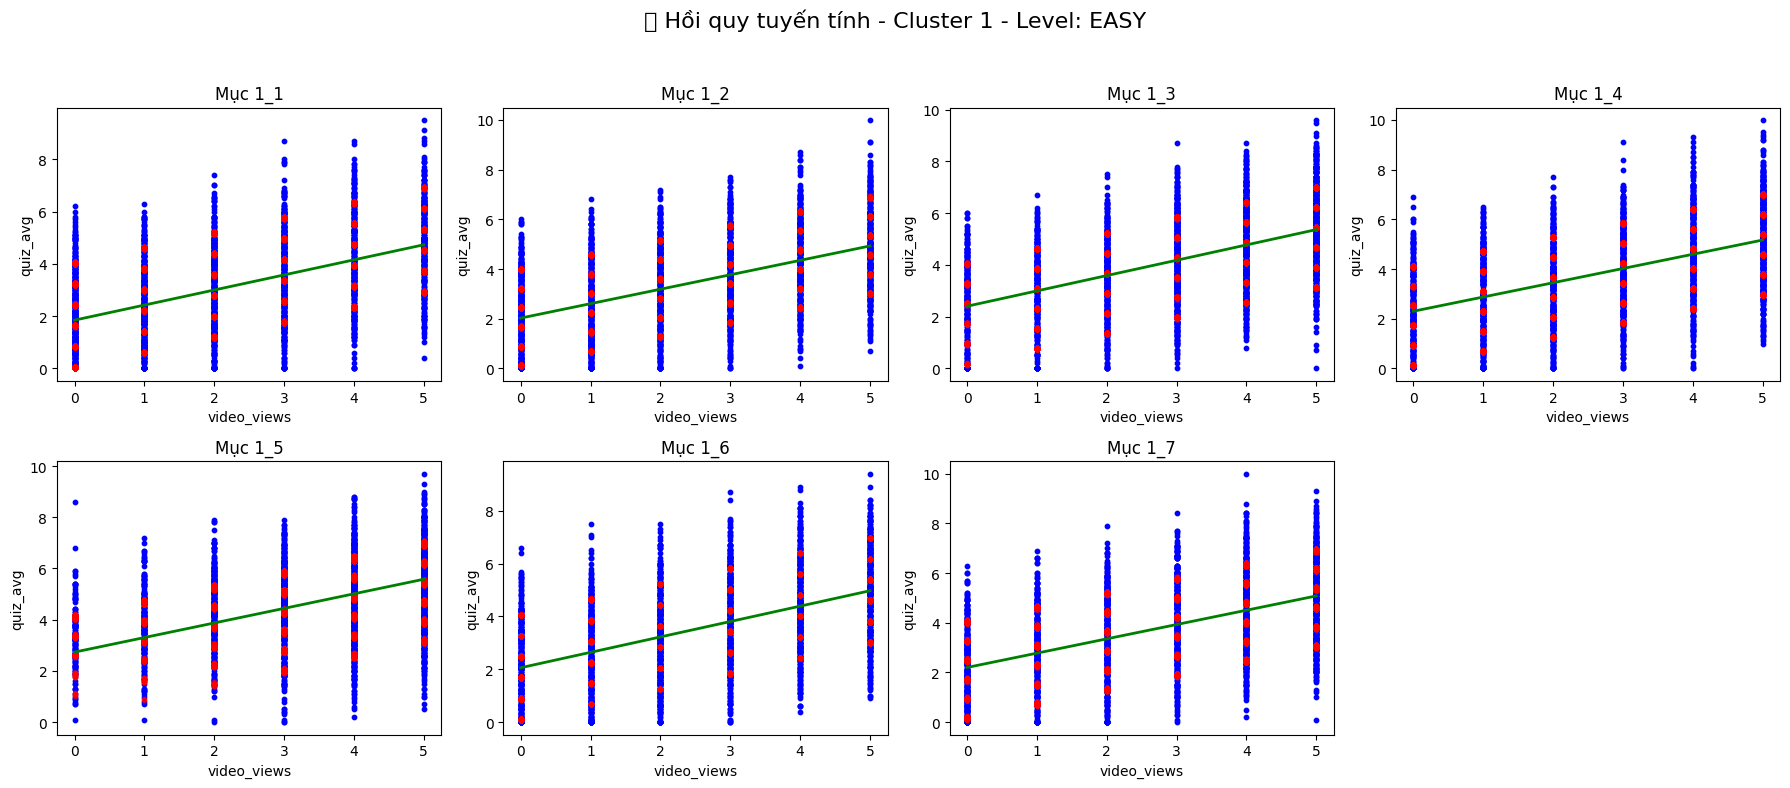

/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KL

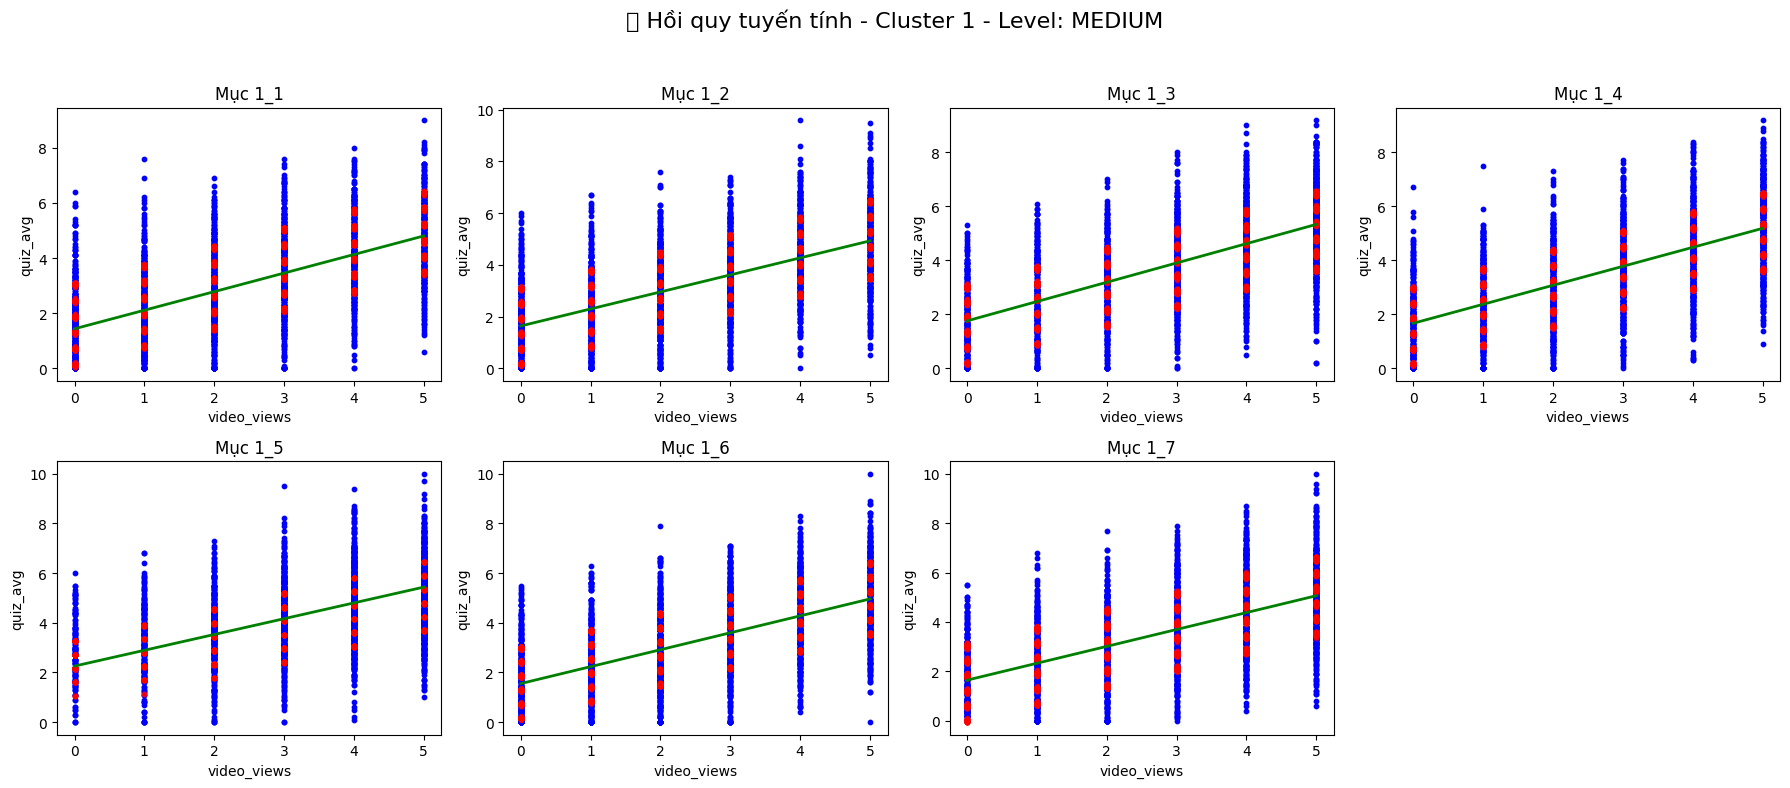

/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KL

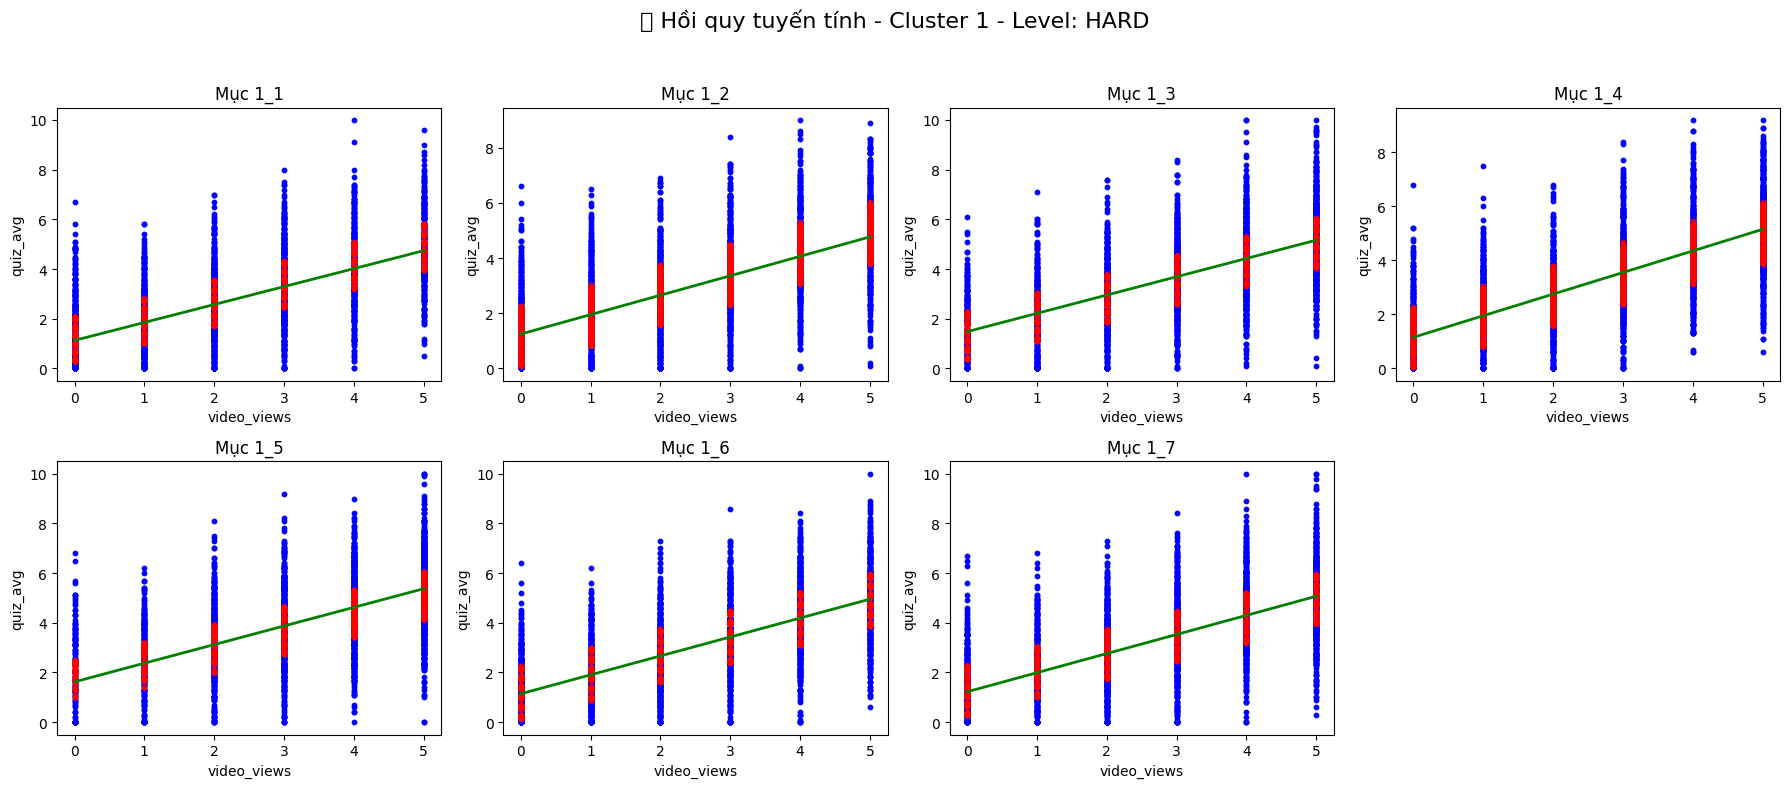

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

models_c0 = joblib.load("models/models_cluster_1.pkl")
sections = [f"1_{i}" for i in range(1, 8)]
levels = ["easy", "medium", "hard"]

# Dữ liệu cluster 1
df = df_c1

for level in levels:
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
    fig.suptitle(f"📘 Hồi quy tuyến tính - Cluster 1 - Level: {level.upper()}", fontsize=16)
    
    for i, section in enumerate(sections):
        key = f"{level}_{section}"
        row, col = divmod(i, 4)
        ax = axes[row, col]

        if key not in models_c0:
            ax.set_visible(False)
            continue

        model = models_c0[key]

        # Cột đầu vào
        base_cols = [
            f"video_views_{section}",
            f"pdf_views_{section}",
            "forum_post_count",
            "assignment_status",
            "cluster"
        ]
        if level == "medium":
            base_cols.insert(2, f"quiz_avg_easy_{section}")
        elif level == "hard":
            base_cols.insert(2, f"quiz_avg_easy_{section}")
            base_cols.insert(3, f"quiz_avg_medium_{section}")

        if not all(col in df.columns for col in base_cols):
            ax.set_visible(False)
            continue

        X = df[base_cols]
        y = df[f"quiz_avg_{level}_{section}"]

        feature = f"video_views_{section}"
        if feature not in X.columns:
            ax.set_visible(False)
            continue

        feature_index = X.columns.get_loc(feature)
        x = X[feature].values
        y_pred = model.predict(X)

        # Vẽ các điểm thực tế và dự đoán
        ax.scatter(x, y, color="blue", s=10, label="Thực tế")
        ax.scatter(x, y_pred, color="red", s=10, alpha=0.6, label="Dự đoán")

        # Đường hồi quy
        x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
        X_mean = X.mean().values.reshape(1, -1).repeat(100, axis=0)
        X_mean[:, feature_index] = x_range[:, 0]
        y_line = model.predict(X_mean)
        ax.plot(x_range, y_line, color="green", linewidth=2)

        ax.set_title(f"Mục {section}")
        ax.set_xlabel("video_views")
        ax.set_ylabel("quiz_avg")

    # Ẩn subplot thừa nếu có
    if len(sections) < 8:
        for j in range(len(sections), 8):
            row, col = divmod(j, 4)
            axes[row, col].set_visible(False)

    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Chừa chỗ cho tiêu đề
    plt.show()

/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


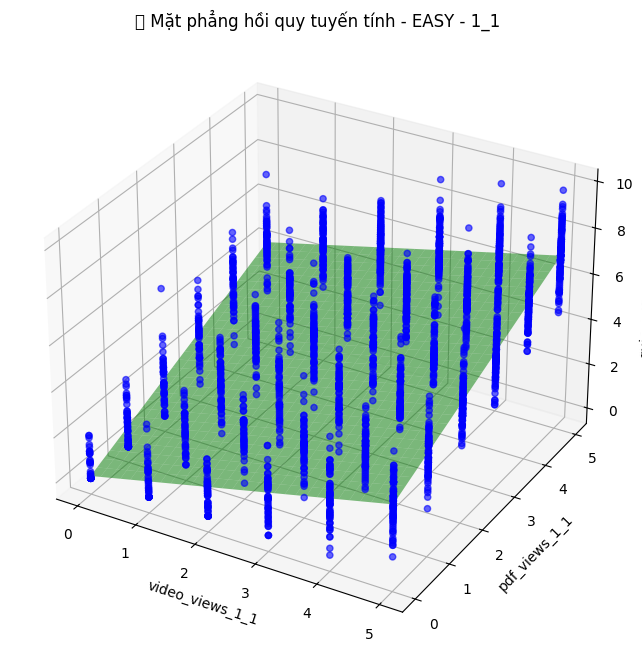

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

section = "1_1"
level = "easy"
key = f"{level}_{section}"
model = models_c0[key]

# Chọn 2 feature muốn vẽ
feat1 = f"video_views_{section}"
feat2 = f"pdf_views_{section}"

# Lấy data và cột tương ứng
base_cols = [
    feat1,
    feat2,
    "forum_post_count",
    "assignment_status",
    "cluster"
]
X = df_c0[base_cols]
y = df_c0[f"quiz_avg_{level}_{section}"]

f1_idx = X.columns.get_loc(feat1)
f2_idx = X.columns.get_loc(feat2)

# Tạo lưới điểm để vẽ mặt phẳng hồi quy
x_surf = np.linspace(X[feat1].min(), X[feat1].max(), 30)
y_surf = np.linspace(X[feat2].min(), X[feat2].max(), 30)
x_grid, y_grid = np.meshgrid(x_surf, y_surf)

# Tạo input giả
X_mean = X.mean().values.reshape(1, -1)
Z_input = X_mean.repeat(x_grid.size, axis=0)
Z_input[:, f1_idx] = x_grid.ravel()
Z_input[:, f2_idx] = y_grid.ravel()

z_pred = model.predict(Z_input).reshape(x_grid.shape)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ điểm thật
ax.scatter(X[feat1], X[feat2], y, color="blue", alpha=0.6, label="Dữ liệu thực")

# Vẽ mặt phẳng hồi quy
ax.plot_surface(x_grid, y_grid, z_pred, alpha=0.5, color='green', label="Hồi quy")

ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel(f"quiz_avg_{level}_{section}")
ax.set_title(f"📘 Mặt phẳng hồi quy tuyến tính - {level.upper()} - {section}")
plt.show()